In [1]:
import os
import consts
import numpy as np
import pandas as pd
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.feature_selection import SelectKBest
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

In [2]:
# Time segment size in minutes
SEGMENT_SIZE = 15
TIME_SEGMENTS = list(range(0, 91, SEGMENT_SIZE))

In [3]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)

    return scores


def get_number_of_players_per_pos(row):
    str_formation = str(row["formation"])
    num_defenders = int(str_formation[0])
    num_midfielders = sum([int(s) for s in str_formation[1:-1]])
    num_attackers = int(str_formation[-1])
    return num_defenders, num_midfielders, num_attackers

In [4]:
pd.options.mode.copy_on_write = True
df_data_points = pd.read_csv(consts.DATA_POINTS_FILE_PATH)
df_match_kpi = pd.read_csv(consts.MATCH_KPI_FILE_PATH)
df_data_points = df_data_points.merge(df_match_kpi[["match_id", "team", "home_or_away"]], on=["match_id", "team"])
df_data_points["timestamp"] = pd.to_datetime(df_data_points["timestamp"])
df_data_points["minutes"] = df_data_points["timestamp"].apply(lambda t: t.hour * 60 + t.minute)
df_data_points["minutes_stratified"] = (df_data_points["minutes"]/SEGMENT_SIZE).astype(int)
df_433_form = df_data_points.loc[df_data_points["formation"] == 433]
df_433_form["event_occurred"] = (df_433_form["type"] == "Shot") & (df_433_form.get("shot_outcome") == "Goal")

In [5]:
df1_x = df_433_form[["type", "goal_difference", "number_of_goals", "home_or_away"]].copy()
#df1_x = df_433_form[["type", "goal_difference", "number_of_goals", "home_or_away", "event_occurred", "minutes"]].copy()
df1_y = df_433_form[["event_occurred", "minutes"]].to_records(index=False)
#df1_x["formation"] = df1_x["type"].astype("category")

df1_x["type"] = df1_x["type"].astype("category")
df_type_hot_encoded = OneHotEncoder().fit_transform(df1_x[["type"]])
data_x = pd.concat([df1_x, df_type_hot_encoded], axis=1)
data_x.drop(columns="type", inplace=True)
for c in data_x.columns:
    data_x[c] = data_x[c].astype(int)

In [6]:
pipe = Pipeline(
    [
        ("select", SelectKBest(fit_and_score_features, k=3)),
        ("model", CoxPHSurvivalAnalysis())
    ]
)
param_grid = {"select__k": np.arange(1, data_x.shape[1] + 1)}
cv = KFold(n_splits=3, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=cv)
gcv.fit(data_x, df1_y)

results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=True)
print(results.loc[:, ~results.columns.str.endswith("_time")])

  param_select__k            params  split0_test_score  split1_test_score  \
0               1  {'select__k': 1}           0.783807           0.788331   
1               2  {'select__k': 2}           0.858818           0.788331   
2               3  {'select__k': 3}           0.858818           0.868347   
3               4  {'select__k': 4}           0.858818           0.868347   
4               5  {'select__k': 5}           0.859501           0.869411   
5               6  {'select__k': 6}           0.860424           0.872026   
6               7  {'select__k': 7}           0.860424           0.872026   
7               8  {'select__k': 8}           0.860424           0.872026   

   split2_test_score  mean_test_score  std_test_score  rank_test_score  \
0           0.781644         0.784594        0.002786                8   
1           0.781644         0.809597        0.034911                7   
2           0.864042         0.863736        0.003896                5   
3         

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, df1_y, test_size=0.2, stratify=df1_y["event_occurred"], random_state=0
)

rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
cphsa = CoxPHSurvivalAnalysis()
    
cphsa.fit(x_train, y_train)
rsf.fit(x_train, y_train)

series = pd.Series(cphsa.coef_, index=data_x.columns)

print(series)

goal_difference         0.026789
number_of_goals        -0.288517
home_or_away            0.077247
type=Foul Committed     0.290273
type=Half End          -0.270425
type=Shot              20.432613
type=Starting XI       -0.718749
type=Tactical Shift     0.107375
dtype: float64


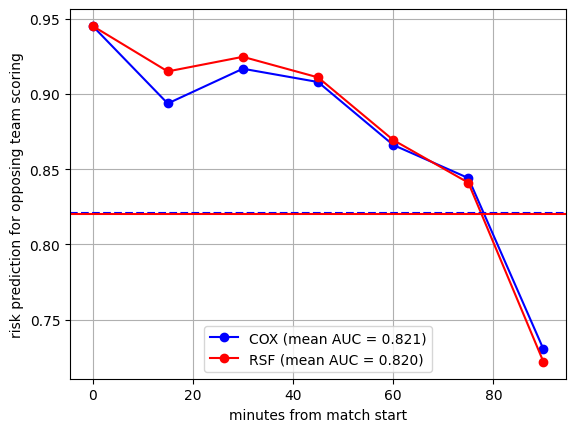

In [12]:
chf_func = cphsa.predict_cumulative_hazard_function(x_test, return_array=False)
rsf_chf_func = rsf.predict_cumulative_hazard_function(x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(TIME_SEGMENTS) for chf in rsf_chf_func])
risk_scores = np.row_stack([chf(TIME_SEGMENTS) for chf in chf_func])

auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, TIME_SEGMENTS)
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, TIME_SEGMENTS)

plt.plot(TIME_SEGMENTS, auc, marker="o", color="blue", label=f"COX (mean AUC = {mean_auc:.3f})")
plt.plot(TIME_SEGMENTS, rsf_auc, "o-", color="red", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.axhline(mean_auc, linestyle="--", color="blue",)
plt.axhline(rsf_mean_auc, linestyle="-", color="red")
plt.xlabel("minutes from match start")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)
plt.show(block=True)